In [1]:
# call __init_ to set notebook seed
import set_notebook_env
import pandas as pd
import matplotlib.pyplot as plt

loader = set_notebook_env.set_env(data_dir="../data/", min_ratings=0)
    

In [2]:
loader.load_raw()
loader.merge()
df = loader.merged_df

In [3]:
# Calculate and display the proportion of missing values per column
# show only columns with missing values
df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False) / df.shape[0]



would_take_again_prop    0.864727
avg_rating               0.221254
avg_difficulty           0.221254
num_ratings              0.221254
pepper                   0.221254
num_online_ratings       0.221254
major                    0.221254
university               0.221254
state                    0.221254
dtype: float64

In [4]:
# Check for logical inconsistencies in gender columns
(df["male"] & df["female"]).sum()


np.int64(2213)

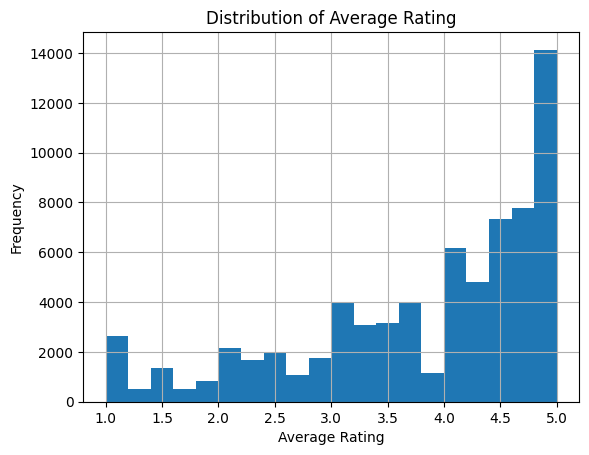

In [5]:
df["avg_rating"].hist(bins=20)
plt.title("Distribution of Average Rating")
plt.xlabel("Average Rating")
plt.ylabel("Frequency")
plt.show()

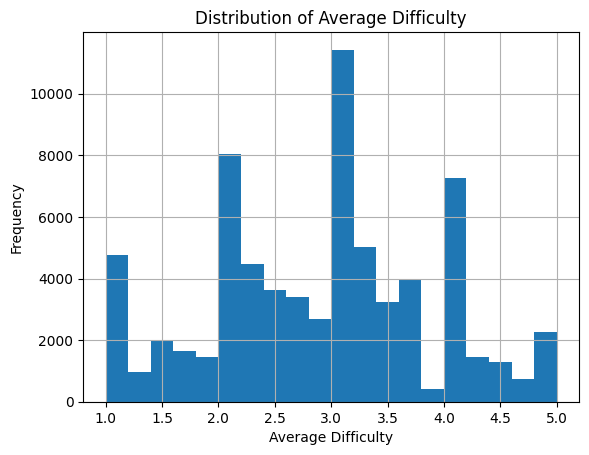

In [6]:
df["avg_difficulty"].hist(bins=20)
plt.title("Distribution of Average Difficulty")
plt.xlabel("Average Difficulty")
plt.ylabel("Frequency")
plt.show()

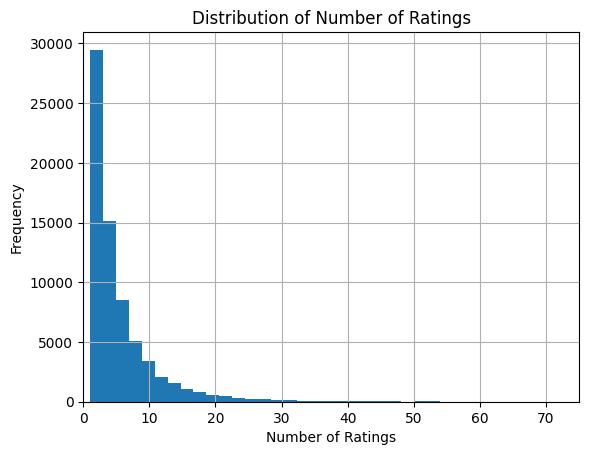

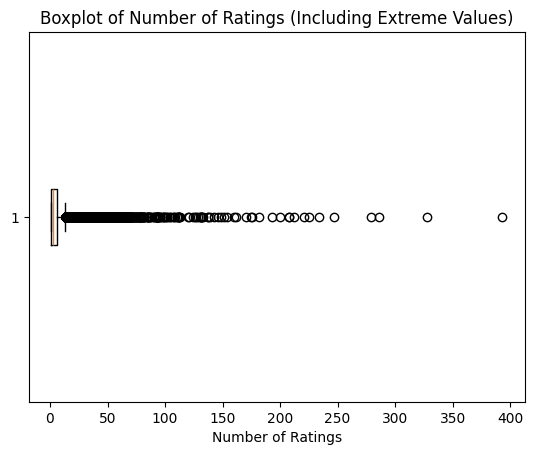

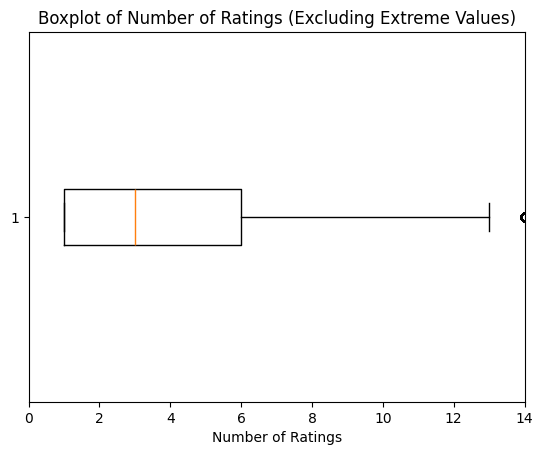

In [29]:
df["num_ratings"].hist(bins=200)
plt.title("Distribution of Number of Ratings")
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.xlim(0, 75)

# plot boxplot of num_ratings
plt.figure()
plt.boxplot(df["num_ratings"].dropna(), vert=False)
plt.title("Boxplot of Number of Ratings (Including Extreme Values)")
plt.xlabel("Number of Ratings")


# exluding outliers for better visualization
plt.figure()
plt.boxplot(df["num_ratings"].dropna(), vert=False)
plt.title("Boxplot of Number of Ratings (Excluding Extreme Values)")
plt.xlabel("Number of Ratings")
plt.xlim(0, 14)
plt.show()


In [9]:
loader.clean()
clean_df = loader.cleaned_df
loader.cleaning_info

# % dropped rows
(len(df) - len(clean_df)) / len(df) * 100, loader.cleaning_info

(24.587282516797934,
 {'dropped_low_rating_count': 19889,
  'dropped_missing_ratings': 0,
  'dropped_inconsistent_gender': 2213})